# Packages

In [122]:
#%cd /content/drive/MyDrive/MscThesis
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import os
import umap
import pandas as pd
import time
import gwpy
import nds2 # conda config --add channels conda-forge \n conda install python-nds2-client
import numba
import h5py
from gwpy.table import EventTable
from gwpy.table import GravitySpyTable
from gwpy.detector import ChannelList, Channel
from gwpy.time import tconvert
from gwpy.timeseries import TimeSeries #if this does not work, remove h5py and reinstall h5py
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerLine2D
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
import torchvision
import torchvision.models
import torchvision.transforms as transforms
from torch.optim import SGD, Adam, AdamW
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import DatasetFolder, ImageFolder
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, \
accuracy_score
from avalanche.models import SlimResNet18, MTSlimResNet18, SimpleCNN
from avalanche.models import as_multitask, IncrementalClassifier
from avalanche.models.utils import avalanche_model_adaptation
from avalanche.training import Naive, LwF, GenerativeReplay, ICaRLLossPlugin, ICaRL, EWC, AR1, LFL, AGEM
from avalanche.logging import InteractiveLogger, TextLogger, CSVLogger
from avalanche.training.plugins import EvaluationPlugin, ReplayPlugin, LwFPlugin, EarlyStoppingPlugin, AGEMPlugin
from avalanche.training.plugins.lr_scheduling import LRSchedulerPlugin
from avalanche.benchmarks import nc_benchmark, ni_benchmark
from avalanche.benchmarks.utils import AvalancheDataset
from avalanche.benchmarks.scenarios.dataset_scenario import benchmark_from_datasets
from avalanche.benchmarks.scenarios.supervised import class_incremental_benchmark
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics,loss_metrics, \
timing_metrics, cpu_usage_metrics, StreamConfusionMatrix, disk_usage_metrics, gpu_usage_metrics, \
confusion_matrix_metrics, bwt_metrics, forward_transfer_metrics, ram_usage_metrics, images_samples_metrics
from avalanche.evaluation.metrics import Accuracy, BWT, Forgetting, ForwardTransfer
import multiprocessing as mp

import my_utils
import my_architectures
import my_dataloaders
import my_gwpy_and_fractals
import my_transformations

IMG_SIZE = (224,224)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# calculating the amount of workers usable
number_of_workers = mp.cpu_count()
number_of_workers = int(number_of_workers/2)
print(number_of_workers)

4


In [2]:
# Set the environment variables
os.environ["GRAVITYSPY_DATABASE_USER"] = "mla"
os.environ["GRAVITYSPY_DATABASE_PASSWD"] = "gl1tch35Rb4d!"

In [3]:
current_dir = %pwd
print(current_dir)

C:\Users\Brian.Baert\Documents\GitHub\MscThesis


In [4]:
# Setting the correct directories
#train_dir = 'D:\\Users\\Brian\\TrainingSet_CL_1\\TrainingSet_CL_1'
train_dir = 'C:\\Users\\Brian.Baert\\TrainingSet_CL_1'
#train_dir_2 = 'D:\\Users\Brian\\TrainingSet_CL_2\\TrainingSet_CL_2'
train_dir_2 = 'C:\\Users\\Brian.Baert\\TrainingSet_CL_2'
#val_dir = 'D:\\Users\\Brian\\TestSet_CL\\TestSet_CL'
val_dir = 'C:\\Users\\Brian.Baert\\ValidationSet_CL'
#test_dir = 'D:\\Users\\Brian\\TestSet_CL\\TestSet_CL'
test_dir = 'C:\\Users\\Brian.Baert\\TestSet_CL'

# Read in class labels
class_file = open("classes.txt", "r")
classes = class_file.read()
classes = classes.split(", ")

In [5]:
O3b_csv = pd.read_csv('Data/data_o3b_high_confidence.csv')

In [6]:
FD_location = 'C:\\Users\\Brian.Baert\\FD_CL\\final_normalized_data.npy'

In [7]:
fractal_matrices = np.load(FD_location)
fractal_matrices.shape

(3584, 347, 56)

In [10]:
#pd_fractal = pd.DataFrame(fractal_matrices.reshape(fractal_matrices.shape[0], -1))
#pd_fractal

In [8]:
no_glitch = fractal_matrices[0:895]
whistle = fractal_matrices[896:1791]
tomte = fractal_matrices[1792:2687]
scattered_light = fractal_matrices[2688:3584]

In [9]:
labels = []
labels.extend(['No_Glitch'] * 896)
labels.extend(['Whistle'] * 896)
labels.extend(['Tomte'] * 896)
labels.extend(['Scattered_Light'] * 896)
len(labels)
labels=np.array(labels)

## Visualization

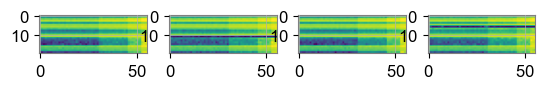

Label for fig 1 is No_Glitch, fig 2 is Whistle, fig 3 is Tomte, fig  is Scattered_Light


In [44]:
plt.close()
fig, ax = plt.subplots(1,4)
ax[0].imshow(fractal_matrices[0][0:20])
ax[1].imshow(fractal_matrices[897][0:20])
ax[2].imshow(fractal_matrices[1793][0:20])
ax[3].imshow(fractal_matrices[2689][0:20])
plt.show()
print(f'Label for fig 1 is {labels[0]}, fig 2 is {labels[897]}, fig 3 is {labels[1793]}, fig  is {labels[2689]}')

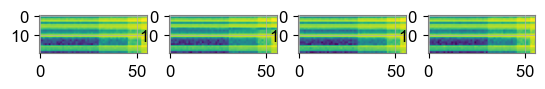

Label for fig 1 is No_Glitch, fig 2 is Whistle, fig 3 is Tomte, fig  is Scattered_Light


In [45]:
fig, ax = plt.subplots(1,4)
ax[0].imshow(fractal_matrices[1][0:20])
ax[1].imshow(fractal_matrices[898][0:20])
ax[2].imshow(fractal_matrices[1794][0:20])
ax[3].imshow(fractal_matrices[2690][0:20])
plt.show()
print(f'Label for fig 1 is {labels[1]}, fig 2 is {labels[898]}, fig 3 is {labels[1793]}, fig  is {labels[2689]}')

In [20]:
f = h5py.File('C:\\Users\\Brian.Baert\\FD_CL\\FD_all_n=3584_2023-05-02.hdf5', 'r')
list(f)
for key in f['metadata'].keys():
    print(key)
 #3584 glitch calculations
#for key in f['fd'].keys():
#    print(key)
len(f['metadata']['channels'][:])

channels
decimate
kstep
overlap
psd_length
scratch
seg_len_start_idx
seg_lengths
times
total_width
whitened


1913

In [39]:
f['metadata']['channels'][121].decode("utf-8")

'L1:ASC-REFL_A_RF45_Q_YAW_OUT_DQ'

In [26]:
bool(f['metadata']['whitened'])

True

In [46]:
def norm_per_chanel(a):
    return (a-a.min(axis=(0,2))[np.newaxis,:,np.newaxis])/np.ptp(a, axis=(0,2))[np.newaxis,:np.newaxis]

times = f['metadata']['times']
data = list()
for t in times:
    data.append(f['fd'][str(t)])
data = np.asarray(data)

In [47]:
data.shape

(3584, 1913, 56)

In [48]:
f['fd']['1238178793.877']

<HDF5 dataset "1238178793.877": shape (1913, 56), type "<f4">

In [49]:
# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(fractal_matrices, labels, test_size=0.2)

# Verify the shapes of the resulting arrays
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (2867, 347, 56)
X_test shape: (717, 347, 56)
Y_train shape: (2867,)
Y_test shape: (717,)


In [82]:
X_train[0][0:4]

array([[0.77841485, 0.78698254, 0.781968  , ..., 0.91315573,
        0.91774493, 0.9001067 ],
       [0.5552012 , 0.5855589 , 0.5846318 , ..., 0.82631016,
        0.84433085, 0.81475574],
       [0.7873107 , 0.8114478 , 0.7831683 , ..., 0.9551451 ,
        0.9761183 , 0.97905314],
       [0.87630266, 0.88795435, 0.88683677, ..., 0.98881024,
        0.9858621 , 0.98327035]], dtype=float32)

In [113]:
label_mapping = {0: 'No_Glitch', 1: 'Whistle', 2: 'Tomte', 3: 'Scattered_Light'}
# Replace values using the dictionary
classes = ['No_Glitch', 'Whistle', 'Tomte', 'Scattered_Light']
print(classes)

['No_Glitch', 'Whistle', 'Tomte', 'Scattered_Light']


In [116]:
import torch
from sklearn.preprocessing import LabelEncoder
data = torch.from_numpy(X_train).float()  # Assuming data is a numpy array
data_test = torch.from_numpy(X_test).float()
# Create a label encoder
le = LabelEncoder()
# Fit the encoder on the training labels
le.fit(Y_train)
le.fit(Y_test)
# Convert string labels to numerical labels
Y_train_encoded = le.transform(Y_train)
Y_test_encoded = le.transform(Y_test)
# Convert the encoded labels to a long tensor
labelsEnc = torch.from_numpy(Y_train_encoded).long()
testLabelsEnc = torch.from_numpy(Y_test_encoded).long()
labelsEnc.unique()

tensor([0, 1, 2, 3])

In [147]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

num_epochs=2

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data, label = self.data[idx][0:21], self.labels[idx]
        return data, label

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=21, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(32)
        self.conv4 = nn.ConvTranspose1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc1 = nn.Linear(64*56, 1024)
        self.fc2 = nn.Linear(1024,256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256,4)


    def forward(self, x):
        x = nn.functional.selu(self.conv1(x))
        x = self.bn1(x)
        x = nn.functional.selu(self.conv2(x))
        x = self.bn2(x)
        x = nn.functional.selu(self.conv3(x))
        x = nn.functional.selu(self.conv4(x))
        x = self.dropout2(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.selu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Assuming your data and labels are loaded into 'data' and 'labels' variables
dataset = CustomDataset(data, labelsEnc)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
testset = CustomDataset(data_test, testLabelsEnc)
testloader = DataLoader(testset, batch_size=16, shuffle=True)


def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
            
# Create an instance of the CNN architecture
model = Net()
model.apply(weights_init)

Net(
  (conv1): Conv1d(21, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3584, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)

In [148]:
x = torch.randn(16,21,56)
output = model(x)
print(output.shape)

torch.Size([16, 4])


In [149]:
import torch.optim as optim

# Define hyperparameters
learning_rate = 0.001
momentum=0.9
epochs = 100
patience = 20
best_loss = float('inf')
best_epoch = 0
early_stop = False

criterion = nn.MSELoss()
# Define optimizer (e.g., Adam optimizer)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-7, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Loop through epochs
for epoch in range(epochs):
    # Loop through data batches
    for data_X, labels_Y in dataloader:
        # Clear gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data_X)
        #print(outputs)
        predicted, _ = torch.max(outputs, 1)
        #print(predicted)
        loss = criterion(predicted, labels_Y.float())  # Convert labels to float for loss calculation

        # Backward pass and parameter update
        loss.backward()
        optimizer.step()

    scheduler.step()
    # Print training information (optional)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    # Check for early stopping
    #if loss.item() < best_loss:
    #    best_loss = loss.item()
    #    best_epoch = epoch
    #elif (epoch - best_epoch) >= patience:
    #    print(f'Early stopping at epoch {epoch+1}, best loss was {best_loss:.4f} at epoch {best_epoch+1}')
    #    early_stop = True
    #    break

if not early_stop:
    print('Finished training')

Epoch [1/100], Loss: 0.0154
Epoch [2/100], Loss: 0.0967
Epoch [3/100], Loss: 0.9548
Epoch [4/100], Loss: 0.6373
Epoch [5/100], Loss: 0.9787
Epoch [6/100], Loss: 3.0449
Epoch [7/100], Loss: 0.7010
Epoch [8/100], Loss: 2.1507
Epoch [9/100], Loss: 0.9500
Epoch [10/100], Loss: 2.4959
Epoch [11/100], Loss: 2.6968
Epoch [12/100], Loss: 0.3516
Epoch [13/100], Loss: 1.3128
Epoch [14/100], Loss: 1.2449
Epoch [15/100], Loss: 1.0920
Epoch [16/100], Loss: 1.8423
Epoch [17/100], Loss: 0.2066
Epoch [18/100], Loss: 1.3149
Epoch [19/100], Loss: 1.6421
Epoch [20/100], Loss: 1.8667
Epoch [21/100], Loss: 0.6878
Epoch [22/100], Loss: 0.9212
Epoch [23/100], Loss: 1.8885
Epoch [24/100], Loss: 1.4856
Epoch [25/100], Loss: 1.2674
Epoch [26/100], Loss: 0.1102
Epoch [27/100], Loss: 0.6184
Epoch [28/100], Loss: 0.8501
Epoch [29/100], Loss: 0.4453
Epoch [30/100], Loss: 1.1951
Epoch [31/100], Loss: 1.1695
Epoch [32/100], Loss: 1.3676
Epoch [33/100], Loss: 1.5335
Epoch [34/100], Loss: 0.3467
Epoch [35/100], Loss: 0

In [150]:
y_pred_list, y_true_list = my_utils.get_predictions(model, testloader)

get_predictions: 850.5566120147705 ms


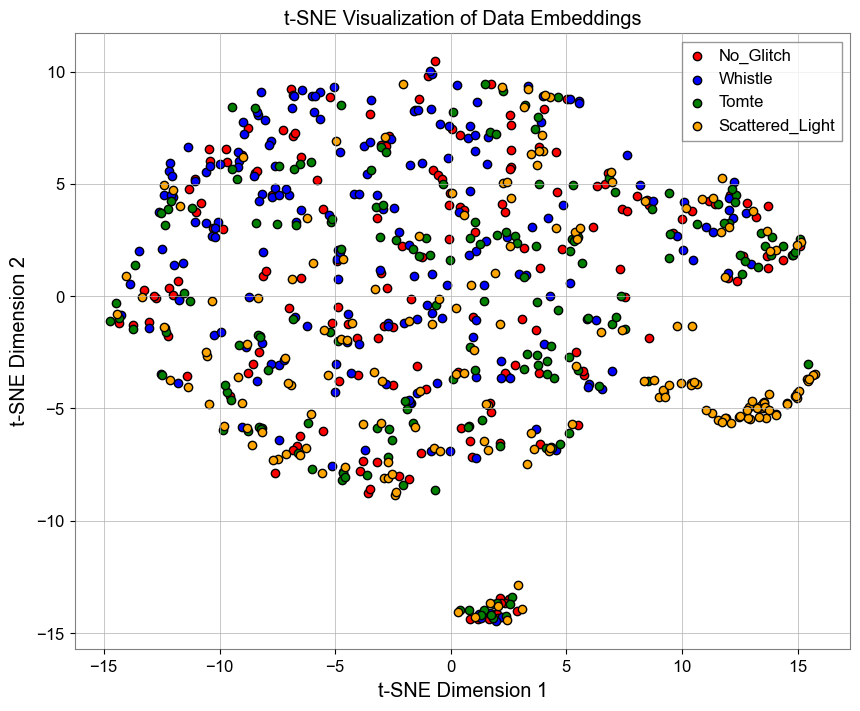

plot_tSNE_data_embedding: 3693.5691833496094 ms


In [151]:
my_utils.plot_tSNE_data_embedding(model, testloader, classes, "Results/tSNE_FractalDimension_test.png")

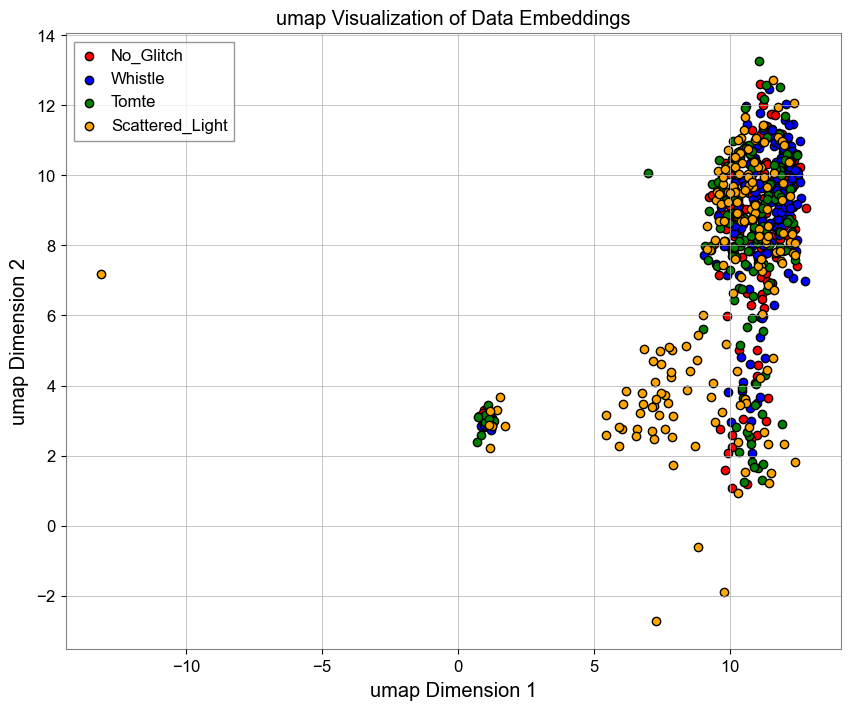

plot_umap_data_embedding: 11227.458715438843 ms


In [152]:
reducer = umap.UMAP(n_neighbors=15, metric='euclidean', n_components=2, spread=0.5, min_dist=0.2, densmap=True)
my_utils.plot_umap_data_embedding(model, testloader, classes, reducer, "Results/umap_FractalDimension_test.png")

In [153]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

In [154]:
f1

array([0.        , 0.        , 0.        , 0.40311804])

In [155]:
cm

array([[  0,   0,   0, 171],
       [  0,   0,   0, 196],
       [  0,   0,   0, 169],
       [  0,   0,   0, 181]], dtype=int64)